In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Load and process data

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [4]:
data = pd.read_pickle('../data/data_proton_photonsum_15_2133.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = pd.read_pickle('../data/data_cond_photonsum_15_2133_15_3273.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (48714, 56, 30) max: 678.0
Loaded cond:  (48714, 12) max: 7000.0 min: -7000.0


In [5]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum'], inplace=True)
data_cond.columns, len(data_cond.columns)

(Index(['Pdg', 'Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge'], dtype='object'),
 10)

In [6]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "gan"

EXPERIMENT_DIR_NAME = f"{NAME}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

Experiment DIR:  gan_13_03_2023_17_02


In [7]:
def create_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

In [8]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    filepath = f"../models/{EXPERIMENT_DIR_NAME}/"
    create_dir(filepath)
    with open(filepath+out_fnm, mode="w") as f:
        f.write(res)

In [9]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

data max 6.5206213 min 0.0
cond max 21.432093 min -35.632454


In [10]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(38971, 56, 30) (9743, 56, 30) (38971, 10) (9743, 10)


In [11]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
fake_cond =  tf.data.Dataset.from_tensor_slices(y_train).shuffle(12800).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond, fake_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_fake_cond =  tf.data.Dataset.from_tensor_slices(y_test).shuffle(12800).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond,val_fake_cond)).shuffle(12800)

### Define Model

In [12]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from tensorflow import keras

In [30]:
latent_dim = 10
cond_dim = 10
poz_dim = 6

############################ generator ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

layer_1 = Dense(128*2)(inputs)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

layer_2 = Dense(128*28*15)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

reshaped = Reshape((28, 15, 128))(layer_2_a)
# reshaped_s = UpSampling2D()(reshaped)

conv1 = Conv2D(128, kernel_size=1)(reshaped)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
conv1_a_s = UpSampling2D()(conv1_a)

conv2 = Conv2D(64, kernel_size=1)(conv1_a_s)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

outputs = Conv2D(1, kernel_size=1,activation='relu')(conv2_a)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

############################ discriminator ############################

input_img = Input(shape=[56,30,1],name='input_img')
conv1 = Conv2D(32, kernel_size=3)(input_img)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
conv2 = Conv2D(16, kernel_size=3)(pool1)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_a)
flat = Flatten()(pool2)
cond = Input(shape=(cond_dim,))

inputs2 = Concatenate(axis=1)([flat, cond])
layer_1 = Dense(128)(inputs2)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(64)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
outputs = Dense(1, activation='sigmoid')(layer_2_a)

discriminator = Model([input_img, cond], outputs, name='discriminator')
discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 20)           0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 256)          5376        ['concatenate_4[0][0]']  

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [32]:
def generator_loss(step, fake_output, generated_images, generated_images2, noise, noise2):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

In [35]:
def generator_loss(step, fake_output):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [37]:
EPOCHS = 4
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[20:20+num_examples_to_generate]

In [38]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils.utils import sum_channels_parallel as sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org


def calculate_ws_ch(n_calc):
  ws= [0,0,0,0,0]
  for j in range(n_calc):
    z = np.random.normal(0,1,(x_test.shape[0],10))
    z_c = y_test
    results = generator.predict([z,z_c])
    results = np.exp(results)-1
    try:
      ch_gen = np.array(results).reshape(-1,56,30)
      ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
      for i in range(5):
        ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
      ws =np.array(ws)
    except ValueError as e:
      print(e)
  ws = ws/n_calc
  print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
  for n,score in enumerate(ws):
    print("ch"+str(n+1),f'{score:.2f}',end=" ")


In [39]:
@tf.function
def train_step(batch,step):
    images, cond, noise_cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise,noise_cond], training=True)

      real_output = discriminator([images,cond], training=True)
      fake_output = discriminator([generated_images, noise_cond], training=True)

      gen_loss = generator_loss(step,fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [40]:
history = []
def train(dataset, epochs):
  tf_step =tf.Variable(0, dtype=float)
  step=0
  generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])
  
  for epoch in range(epochs):
    start = time.time()

    for batch in dataset:
      gen_loss, disc_loss =train_step(batch,tf_step)
      history.append([gen_loss,disc_loss,
            100*d_acc_r.result().numpy(),
            100*d_acc_f.result().numpy(),
            100*g_acc.result().numpy(),
            ])
      tf_step.assign_add(1)
      step = step+1

      if step%100==0:
        print("%d [D real acc: %.2f%%] [D fake acc: %.2f%%] [G acc: %.2f%%] "% (
            step,
            100*d_acc_r.result().numpy(),
            100*d_acc_f.result().numpy(),
            100*g_acc.result().numpy()))
      if step%1000==0:
          generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])


    generate_and_save_images(generator,
                             epoch + 1,
                             [seed, seed_cond]
                             )

    # Save the model 
    # generator.save_weights("gen_"+NAME + "_"+ str(epoch) +".h5")
    # discriminator.save_weights("disc_"+NAME + "_"+ str(epoch) +".h5")
    # np.savez("history_"+NAME+".npz",np.array(history))

    calculate_ws_ch(min(epoch//5+1,5))

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return history

In [41]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    print(predictions.shape)
    fig, axs = plt.subplots(2, 7, figsize=(15, 4))
    fig.suptitle(f"Epoch {epoch}")
    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, interpolation='none', cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])
    # plt.savefig('../images/proton_photonsum_30/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Train model
##### only for 1 epoch for presentation

(16, 56, 30, 1)


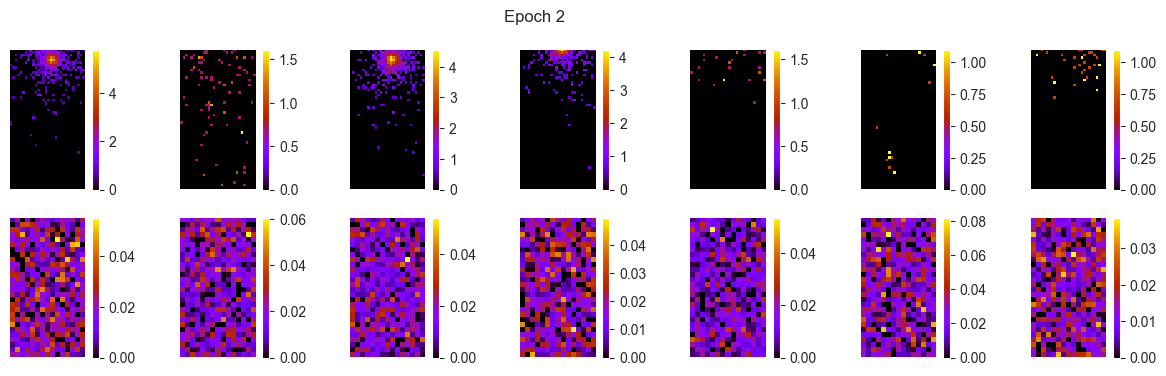

100 [D real acc: 63.93%] [D fake acc: 42.64%] [G acc: 57.36%] 
200 [D real acc: 66.50%] [D fake acc: 44.79%] [G acc: 55.21%] 
300 [D real acc: 67.93%] [D fake acc: 45.90%] [G acc: 54.10%] 
(16, 56, 30, 1)


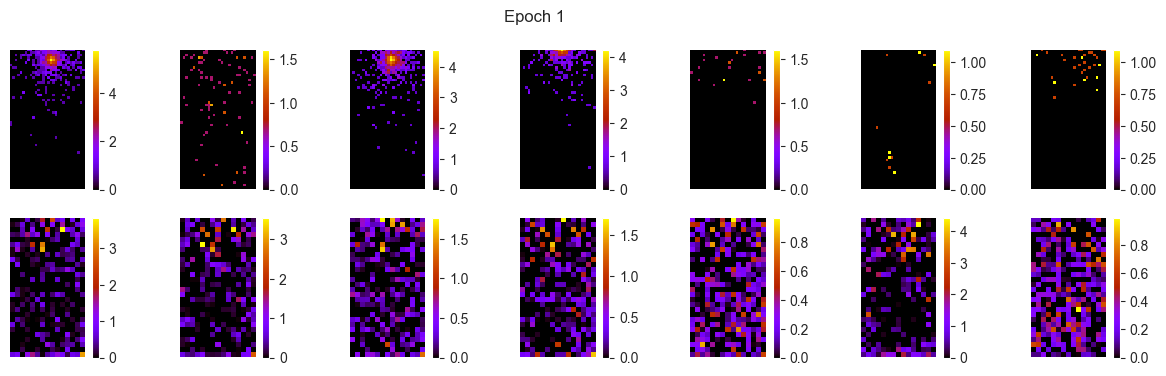

305/305 [==============================] - 2s 5ms/step
ws mean 6689482255217348608.00 ch1 0.49 ch2 267674990149.84 ch3 0.31 ch4 16723705503325104128.00 ch5 16723705505086648320.00 Time for epoch 1 is 47.74875259399414 sec
400 [D real acc: 68.20%] [D fake acc: 48.47%] [G acc: 51.53%] 
500 [D real acc: 69.05%] [D fake acc: 51.39%] [G acc: 48.61%] 
600 [D real acc: 69.81%] [D fake acc: 53.84%] [G acc: 46.16%] 
(16, 56, 30, 1)


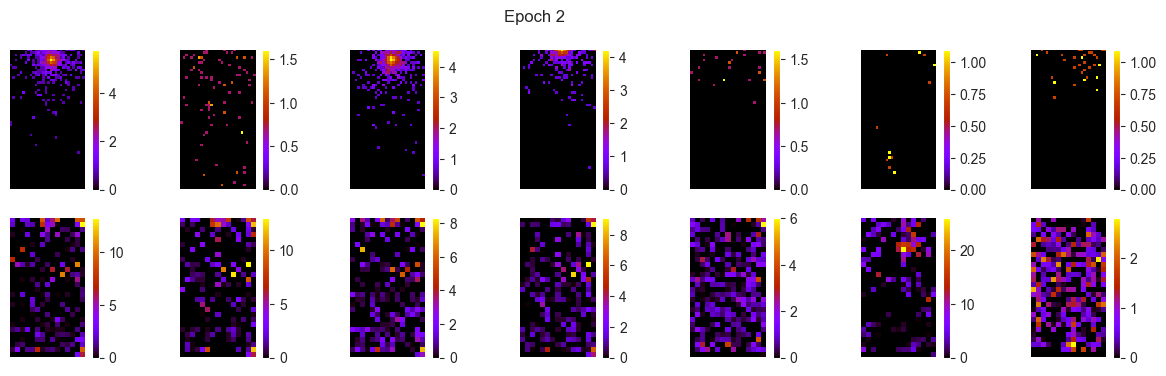

305/305 [==============================] - 1s 4ms/step


C:\Users\PB\AppData\Local\Temp\ipykernel_16624\2982202894.py:18: RuntimeWarning: overflow encountered in exp
  results = np.exp(results)-1
C:\Users\PB\Documents\GithubRepos\Generative-Models-for-CERN-Fast-Simulations\utils\utils.py:77: RuntimeWarning: invalid value encountered in multiply
  ch1 = (data * mask1).sum(axis=1).sum(axis=1)
C:\Users\PB\Documents\GithubRepos\Generative-Models-for-CERN-Fast-Simulations\utils\utils.py:78: RuntimeWarning: invalid value encountered in multiply
  ch2 = (data * mask2).sum(axis=1).sum(axis=1)
C:\Users\PB\Documents\GithubRepos\Generative-Models-for-CERN-Fast-Simulations\utils\utils.py:79: RuntimeWarning: invalid value encountered in multiply
  ch3 = (data * mask3).sum(axis=1).sum(axis=1)
C:\Users\PB\Documents\GithubRepos\Generative-Models-for-CERN-Fast-Simulations\utils\utils.py:80: RuntimeWarning: invalid value encountered in multiply
  ch4 = (data * mask4).sum(axis=1).sum(axis=1)
C:\Users\PB\Documents\GithubRepos\Generative-Models-for-CERN-Fast-Sim

ws mean nan ch1 nan ch2 nan ch3 nan ch4 nan ch5 nan Time for epoch 2 is 34.71511363983154 sec


In [42]:
history=train(dataset_with_cond, 2)